# MovieLens Application
https://grouplens.org/datasets/movielens/

In [185]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
import pandas as pd
import numpy as np

In [187]:
import sys
import gc

sys.path.append("/home/ubuntu/rankability_toolbox")

In [188]:
import pandas as pd
import numpy as np

In [5]:
import pyrankability

In [141]:
import dask
dask.config.set({'temporary_directory': '/dev/shm'})

## Movie Lens Data

In [6]:
DATA_DIR='ml-25m'
PROCESS=False

In [7]:
links = pd.read_csv("%s/links.csv"%DATA_DIR)
display(links.head())
links["tmdbId"] = links["tmdbId"].fillna(-1).astype(int)
display(links.head())
display(links.dtypes)

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

movieId  imdbId  tmdbId
0        1  114709     862
1        2  113497    8844
2        3  113228   15602
3        4  114885   31357
4        5  113041   11862

movieId    int64
imdbId     int64
tmdbId     int64
dtype: object

In [8]:
movies = pd.read_csv("%s/movies.csv"%DATA_DIR)
display(movies.head())
movies["genres"] = movies["genres"].str.split("|")
display(movies.head())

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

movies = movies.join(pd.DataFrame(mlb.fit_transform(movies['genres']),
                          columns=mlb.classes_,
                          index=movies.index))
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
62418   209157                           We (2018)   
62419   209159           Window of the Soul (2001)   
62420   209163                    Bad Poems (2018)   
62421   209169                 A Girl Thing (2001)   
62422   209171      Women of Devil's Island (1962)   

                                                  genres  (no genres listed)  \
0      [Adventure, Animation, Children, Comedy, Fantasy]                   0   
1                         [Adventure, Children, Fantasy]                   0   
2                                      [Comedy, Romance]                   0   
3                               [Comedy, Drama, Romance]                   0   
4                                               [Comedy]                   0   
...                                                  ...                 ...   
62418                                            [Drama]                   0   
62419                                      [Documentary]                   0   
62420                                    [Comedy, Drama]                   0   
62421                               [(no genres listed)]                   1   
62422                         [Action, Adventure, Drama]                   0   

       Action  Adventure  Animation  Children  Comedy  Crime  ...  Film-Noir  \
0           0          1          1         1       1      0  ...          0   
1           0          1          0         1       0      0  ...          0   
2           0          0          0         0       1      0  ...          0   
3           0          0          0         0       1      0  ...          0   
4           0          0          0         0       1      0  ...          0   
...       ...        ...        ...       ...     ...    ...  ...        ...   
62418       0          0          0         0       0      0  ...          0   
62419       0          0          0         0       0      0  ...          0   
62420       0          0          0         0       1      0  ...          0   
62421       0          0          0         0       0      0  ...          0   
62422       1          1          0         0       0      0  ...          0   

       Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0           0     0        0        0        0       0         0    0        0  
1           0     0        0        0        0       0         0    0        0  
2           0     0        0        0        1       0         0    0        0  
3           0     0        0        0        1       0         0    0        0  
4           0     0        0        0        0       0         0    0        0  
...       ...   ...      ...      ...      ...     ...       ...  ...      ...  
62418       0     0        0        0        0       0         0    0        0  
62419       0     0        0        0        0       0         0    0        0  
62420       0     0        0        0        0       0         0    0        0  
62421       0     0        0        0        0       0         0    0        0  
62422       0     0        0        0        0       0         0    0        0  

[62423 rows x 23 columns]

In [10]:
select_movieId = int(movies.loc[movies.title.str.find("Napoleon Dy")>=0].movieId) #1202

In [11]:
ratings = pd.read_csv("%s/ratings.csv"%DATA_DIR)
ratings["movieId"] = ratings["movieId"].astype("category").cat.as_ordered()
display(ratings.head())
display(ratings.dtypes)

userId movieId  rating   timestamp
0       1     296     5.0  1147880044
1       1     306     3.5  1147868817
2       1     307     5.0  1147868828
3       1     665     5.0  1147878820
4       1     899     3.5  1147868510

userId          int64
movieId      category
rating        float64
timestamp       int64
dtype: object

## How many movies did a user rank?

In [12]:
lengths = ratings.groupby('userId').apply(len)
print('On average the number of movies ranked by a user is',lengths.mean())

On average the number of movies ranked by a user is 153.80793153727367


## Find users who ranked Nap. Dyn.

In [13]:
user_mask = ratings.groupby('userId').apply(lambda x: sum(x.movieId == select_movieId)>0)

In [14]:
print('Fraction of users who ranked the movie:',sum(user_mask)/len(user_mask))

Fraction of users who ranked the movie: 0.06339323616810527


In [15]:
select_users = user_mask.loc[user_mask].index
select_users

Int64Index([    12,     57,     62,     93,    104,    142,    155,    169,
               171,    174,
            ...
            162443, 162484, 162485, 162495, 162498, 162512, 162515, 162516,
            162521, 162538],
           dtype='int64', name='userId', length=10304)

In [16]:
import dask.dataframe as dd
select_ratings = dd.from_pandas(ratings.set_index('userId').loc[select_users,:].reset_index(),npartitions=12).set_index('movieId')
select_ratings

Dask DataFrame Structure:
               userId   rating timestamp
npartitions=12                          
1               int64  float64     int64
434               ...      ...       ...
...               ...      ...       ...
102445            ...      ...       ...
209147            ...      ...       ...
Dask Name: sort_index, 98 tasks

In [17]:
select_ratings.head()

userId  rating   timestamp
movieId                            
1            12     4.0  1167582601
1         45118     4.5  1133316857
1        133321     4.5  1115920012
1          6810     4.5  1117066773
1        133314     1.5  1490337197

/data/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


On average the number of movies ranked by a user is 554.2385481366459


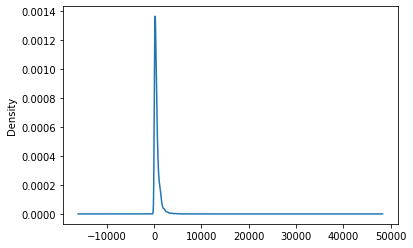

In [18]:
select_lengths = select_ratings.groupby('userId').apply(len).compute()
print('On average the number of movies ranked by a user is',select_lengths.mean())
select_lengths.plot.density()

## To keep this initial experiment small, let's say we will only look at users with less than 400 movies

In [19]:
select_lengths2 = select_lengths.loc[select_lengths<=300]
select_lengths2

userId
301       235
1060      114
3355      288
3492       56
3721      108
         ... 
160397    233
160591     83
161019    147
161780     34
161898    258
Length: 4232, dtype: int64

## Grab the movies from a single user

In [20]:
userId = select_lengths2.index[0]
user_ratings = select_ratings.reset_index().set_index('userId').loc[userId].compute()
#user_ratings.reset_index()

In [21]:
user_ratings

movieId  rating   timestamp
userId                            
301     105844     3.0  1484676871
301       1288     3.0  1484676898
301        364     3.0  1484675580
301      71535     3.0  1484675479
301       5952     3.5  1484962138
...        ...     ...         ...
301      51255     3.0  1484676633
301      55820     2.5  1484676629
301       2502     4.0  1484675746
301     139385     3.0  1484676598
301       7438     3.5  1484675451

[235 rows x 3 columns]

In [174]:
user_ratings['movieId'] = user_ratings['movieId'].astype(int)

In [175]:
user_ratings.set_index('movieId').loc[select_movieId]

rating       4.500000e+00
timestamp    1.484676e+09
Name: 8376, dtype: float64

In [176]:
def construct_D(X_for_graph):
    D = np.zeros((len(X_for_graph.columns),len(X_for_graph.columns)))
    C = np.zeros((len(X_for_graph.columns),len(X_for_graph.columns)))
    for i in range(X_for_graph.shape[0]):
        for j,c1 in enumerate(X_for_graph.columns):
            vj = X_for_graph.iloc[i,j]
            if np.isnan(vj):
                continue
            for k in range(j+1,len(X_for_graph.columns)):
                c2 = X_for_graph.columns[k]
                vk = X_for_graph.iloc[i,k]
                if np.isnan(vk):
                    continue
                if vj == vk:
                    pass
                #    D[j,k] += 0.5
                elif vj > vk:
                    D[j,k] += 1 #vj - vk
                    #C[j,k] += 1
                    #C[k,j] += 1
                else:
                    D[k,j] += 1#vk - vj
                    C[k,j] += 1
                    C[j,k] += 1
    D_df = pd.DataFrame(D/C)
    D_df = D_df.fillna(0)
    D_df = round(D_df*10)
    D_df.columns = list(X_for_graph.columns)
    D_df.set_index(D_df.columns,inplace=True)
    return D_df

In [194]:
train_select_ratings.median(axis=1)

userId
12        4.25
57        4.50
62        4.50
93        3.25
104       5.00
          ... 
162512    4.00
162515    3.00
162516    4.00
162521    4.25
162538    4.00
Length: 10111, dtype: float64

movieId  318     364     589     733     778     1079    1252    1673    \
userId                                                                    
12         0.25   -1.25     NaN     NaN    0.75    0.25     NaN   -0.25   
57         0.00    0.00     NaN     NaN   -0.50     NaN     NaN     NaN   
62          NaN     NaN     NaN     NaN    0.00     NaN     NaN     NaN   
93          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
104         NaN     NaN    0.00     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
162512     0.50    0.00   -2.00    0.00     NaN     NaN     NaN     NaN   
162515      NaN    0.50     NaN     NaN     NaN     NaN     NaN     NaN   
162516     0.00    0.00    1.00   -0.50    0.00    0.00    -0.5    0.00   
162521      NaN     NaN   -1.25   -0.75    0.25    0.25     NaN     NaN   
162538      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  2329    2403    ...  3147    5952    7254    7438    55820   89864   \
userId                   ...                                                   
12          NaN     NaN  ...     NaN     NaN     NaN     NaN    0.25     NaN   
57         0.00     NaN  ...     NaN   -2.00   -0.50   -0.50     NaN     NaN   
62         0.00     NaN  ...    0.00    0.00     NaN    0.00   -0.50     NaN   
93          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
104         NaN     NaN  ...     NaN     NaN     NaN   -0.50     NaN     NaN   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
162512      NaN     NaN  ...     NaN    0.00     NaN    0.50     NaN     NaN   
162515      NaN     NaN  ...     NaN    0.50   -1.00    0.00     NaN     NaN   
162516     0.50    -0.5  ...    0.50   -1.00    0.00    0.00    0.50     0.0   
162521    -0.25     NaN  ...   -0.25    0.25    0.25    0.25     NaN     NaN   
162538     0.00     NaN  ...     NaN    0.00     NaN     NaN     NaN     NaN   

movieId  112183  112552  122882  148888  
userId                                   
12          NaN     NaN     NaN     NaN  
57          NaN     NaN     NaN     NaN  
62          NaN     NaN     NaN     NaN  
93         0.25     NaN     NaN     NaN  
104         NaN     NaN     NaN     NaN  
...         ...     ...     ...     ...  
162512      NaN     NaN     NaN     NaN  
162515      NaN     NaN     NaN     NaN  
162516     0.50     0.0    -0.5     NaN  
162521    -1.25     NaN     NaN     NaN  
162538      NaN     NaN     NaN     NaN  

[10111 rows x 23 columns]

In [183]:
from sklearn.neighbors import NearestNeighbors

info = {}

n_neighbors = 100
num_iterations = 1
for iteration in range(num_iterations):
    train_user_ratings = user_ratings.set_index("movieId").sample(frac=0.9)
    test_user_ratings = user_ratings.set_index("movieId").drop(train_user_ratings.index)
    #train_user_ratings.reset_index(inplace=True)
    #test_user_ratings.reset_index(inplace=True)    
    if select_movieId in list(train_user_ratings.index): # put it in the test dataset
        train_user_ratings,test_user_ratings = test_user_ratings,train_user_ratings
    train_movieIds = list(train_user_ratings.index)
    test_movieIds = list(test_user_ratings.index)
    train_select_ratings = select_ratings.loc[train_movieIds,:].compute(scheduler="processes").reset_index()#.set_index(['userId','movieId'])
    #train_select_ratings["rating"] = train_select_ratings["rating"].astype(pd.SparseDtype(float))
    train_select_ratings["movieId"] = train_select_ratings["movieId"].astype(int)
    train_select_ratings = train_select_ratings.pivot_table(index='userId',columns='movieId',values='rating')
    # Now normalize the data by subtracting the median
    train_select_ratings = train_select_ratings.subtract(train_select_ratings.median(axis=1),axis=0)
    #import pdb; pdb.set_trace()
    test_select_ratings = select_ratings.loc[test_movieIds,:].compute(scheduler="processes").reset_index()
    test_select_ratings["movieId"] = test_select_ratings["movieId"].astype(int)
    test_select_ratings = test_select_ratings.pivot_table(index='userId',columns='movieId',values='rating')
    X = train_select_ratings.apply(lambda x: x.fillna(x.median())>0,axis=0)
    nbrs = NearestNeighbors(n_neighbors=min(n_neighbors,len(X)-1), algorithm='ball_tree').fit(X.drop(userId))
    distances, indices = nbrs.kneighbors(X.loc[[userId]])
    X_for_graph = test_select_ratings.drop(userId).iloc[indices.flat,:]
    #X_for_graph = test_select_ratings.drop(userId).sample(n_neighbors)
    D = construct_D(X_for_graph)
    k,details = pyrankability.hillside.count_lp(D.values,relaxation_method="constraints")
    info[iteration] = {}
    info[iteration]['D'] = D
    info[iteration]['k'] = k
    info[iteration]['details'] = details

/data/env/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/data/env/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/rankability_toolbox/pyrankability/hillside.py:253: RuntimeWarning: invalid value encountered in subtract
  c[i,j] = np.count_nonzero(D[:,j]-D[:,i]<0) + np.count_nonzero(D[i,:]-D[j,:]<0)
/home/ubuntu/rankability_toolbox/pyrankability/hillside.py:253: RuntimeWarning: invalid value encountered in less
  c[i,j] = np.count_nonzero(D[:,j]-D[:,i]<0) + np.count_nonzero(D[i,:]-D[j,:]<0)


In [181]:
D

1       111     260     296     318     508     586     593     \
1          0.0     2.0     9.0     5.0     2.0     8.0    23.0     4.0   
111       10.0     0.0    14.0     6.0     4.0    55.0    85.0     8.0   
260       10.0    10.0     0.0     7.0     5.0    18.0    60.0     7.0   
296       10.0    10.0    10.0     0.0     5.0    45.0    48.0    15.0   
318       10.0    10.0    10.0    10.0     0.0   120.0   145.0    36.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
122886    10.0    10.0    10.0    10.0    10.0    10.0    10.0    10.0   
127202     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
128360    10.0    10.0    10.0    10.0    10.0    10.0    10.0    10.0   
142488    10.0    10.0    10.0    10.0    10.0    10.0    10.0    10.0   
148888     0.0     0.0     0.0     0.0     0.0     0.0    10.0     0.0   

        608     673     ...  112556  114935  115617  116161  117176  122886  \
1          6.0    50.0  ...     inf     inf   110.0    20.0    40.0    19.0   
111        8.0     inf  ...    30.0    20.0     inf     inf     inf    22.0   
260       11.0   110.0  ...    45.0    15.0    60.0     inf    50.0    32.0   
296       13.0     inf  ...   110.0     inf    45.0    30.0     inf    12.0   
318       25.0   130.0  ...   120.0     inf   110.0     inf     inf    50.0   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
122886    10.0    10.0  ...    10.0     0.0    10.0    10.0    10.0     0.0   
127202     0.0     0.0  ...     0.0    10.0     0.0     0.0     0.0    10.0   
128360    10.0    10.0  ...    10.0    10.0    10.0    10.0    10.0    10.0   
142488    10.0    10.0  ...    10.0    10.0    10.0    10.0    10.0    10.0   
148888     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        127202  128360  142488  148888  
1          inf    13.0    13.0     inf  
111        inf    70.0    13.0     inf  
260        inf    14.0    20.0     inf  
296        inf    50.0    30.0     inf  
318        inf    90.0    20.0     inf  
...        ...     ...     ...     ...  
122886    10.0     5.0     3.0     inf  
127202     0.0     0.0     0.0     inf  
128360    10.0     0.0     2.0     inf  
142488     0.0    10.0     0.0     inf  
148888     0.0     0.0     0.0     0.0  

[118 rows x 118 columns]

In [111]:
select_movieId

8376

In [137]:
D.loc[select_movieId]

1         1.5
50        1.0
110       0.5
111       1.5
364       5.0
         ... 
131724    0.0
139385    0.5
142488    0.0
162566    0.0
165103    0.0
Name: 8376, Length: 117, dtype: float64

8376

In [31]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [84]:
D

32      47      50      110     260     293     356     586     \
32         0.0     3.0     3.0     4.5     3.5     1.5     3.5     7.5   
47         1.0     0.0     3.5     4.0     3.0     2.5     3.5     9.0   
50         2.5     3.5     0.0     6.5     5.0     3.0     5.0     9.5   
110        0.0     0.5     0.0     0.0     0.5     0.5     2.0     3.0   
260        0.5     1.5     1.5     3.0     0.0     2.0     3.5     6.5   
...        ...     ...     ...     ...     ...     ...     ...     ...   
128360     0.5     1.0     0.5     3.5     2.0     0.5     2.0     5.5   
131724     1.5     1.5     1.0     2.5     1.5     0.5     2.0     3.5   
139385     1.0     2.5     1.0     2.0     2.0     0.0     2.5     6.5   
142488     0.0     0.5     0.0     3.0     1.5     0.5     1.5     3.0   
162566     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        673     778     ...  116161  116797  117176  122882  127202  128360  \
32         3.0     3.0  ...     2.0     3.0     4.0     2.5     2.5     3.5   
47         4.5     3.5  ...     3.5     3.5     4.0     3.0     3.5     4.5   
50         6.0     4.0  ...     3.5     3.0     3.5     3.5     2.5     5.5   
110        3.0     1.0  ...     0.5     1.5     2.0     1.5     1.0     1.0   
260        3.5     3.5  ...     1.5     2.5     3.0     2.5     2.0     4.5   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
128360     1.5     0.0  ...     1.0     0.0     1.0     0.5     1.0     0.0   
131724     0.0     1.0  ...     0.5     0.5     1.5     1.0     0.5     1.5   
139385     5.5     2.5  ...     3.5     1.5     2.5     0.0     1.5     3.0   
142488     0.0     0.5  ...     1.0     0.5     1.5     0.0     0.5     0.5   
162566     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        131724  139385  142488  162566  
32         0.5     3.0     2.0     0.0  
47         0.5     4.0     1.5     0.0  
50         0.5     4.5     2.5     0.0  
110        0.0     1.5     0.0     0.0  
260        0.5     3.0     1.0     0.0  
...        ...     ...     ...     ...  
128360     0.5     3.0     1.5     0.0  
131724     0.0     2.0     1.5     0.0  
139385     0.0     0.0     1.5     0.0  
142488     0.0     0.0     0.0     0.0  
162566     0.0     0.0     0.0     0.0  

[118 rows x 118 columns]

In [83]:
all_df.loc[all_df.i == "MOVIE",:]

i       j key  oi   oj             x
11210  MOVIE     858   0  95    0  1.056932e-13
11211  MOVIE     293   0  95    1  9.658940e-14
11212  MOVIE      50   0  95    2  8.992806e-14
11213  MOVIE    2571   0  95    3  8.892886e-14
11214  MOVIE    1214   0  95    4  8.426593e-14
...      ...     ...  ..  ..  ...           ...
11323  MOVIE  103249   0  95  113  1.000000e+00
11324  MOVIE    1721   0  95  114  1.000000e+00
11325  MOVIE   54503   0  95  115  1.000000e+00
11326  MOVIE   51662   0  95  116  1.000000e+00
11327  MOVIE    7325   0  95  117  1.000000e+00

[118 rows x 6 columns]

0


/data/env/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


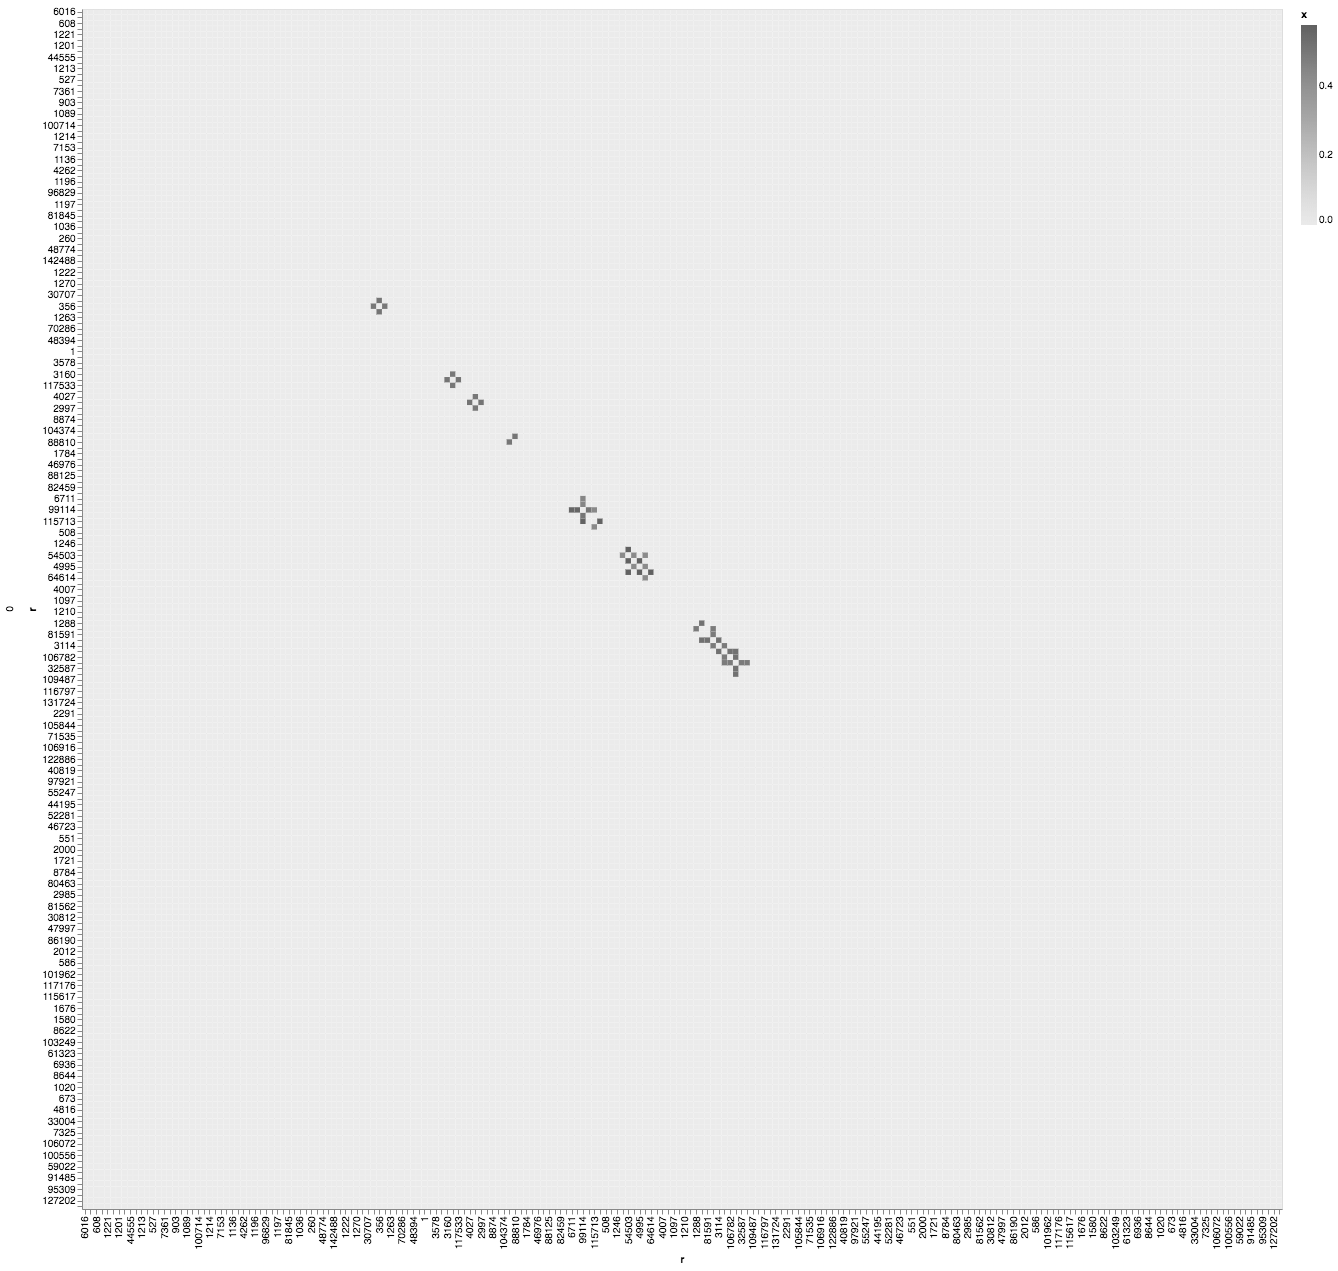

In [184]:
import altair as alt
all_df = pd.DataFrame(columns=["i","j","x","key","oi","oj"])
for key in info.keys():
    print(key)
    x = pyrankability.hillside.threshold_x(info[key]['details']['x'])
    #x=info[key]['details']['x']
    r = np.sum(x,axis=1)
    ixs = np.argsort(-1*r,kind='stable')
    x = pd.DataFrame(x[ixs,:][:,ixs])
    df = x.stack().reset_index()
    df.columns=["i","j","x"]
    df["oi"] = df["i"].copy()
    df["oj"] = df["j"].copy()
    df["i"] = info[key]['D'].columns[ixs[df["i"]]]
    df["j"] = info[key]['D'].columns[ixs[df["j"]]]
    select_ix = df["i"] == select_movieId
    df.loc[select_ix,"i"] = "MOVIE"
    select_ix = df["j"] == select_movieId
    df.loc[select_ix,"j"] = "MOVIE"
    df["key"] = key
    all_df = all_df.append(df)

all_df.loc[(all_df.x == 0) | (all_df.x == 1),"x"] = 0
#all_df = all_df.loc[(all_df.x != 0) & (all_df.x != 1)]
alt.Chart(all_df).mark_square().encode(
    x=alt.X(
        'i:N',
        axis=alt.Axis(labelOverlap="parity"),
        title="r",
        sort=alt.EncodingSortField(field="oi",order="ascending") # The order to sort in
    ),
    y=alt.Y(
        'j:N',
        axis=alt.Axis(labelOverlap="parity"),
        title="r",
        sort=alt.EncodingSortField(field="oj",order="ascending") # The order to sort in
    ),
    color=alt.Color("x",scale=alt.Scale(scheme='greys'))
).properties(
    width=1200,
    height=1200
).facet(
    row=alt.Row("key:N", title=None)
).resolve_scale(x='independent',y='independent')

In [172]:
info[key]['details']['x']

array([[1.00000000e+00, 7.31185238e-12, 7.05471218e-12, 7.25448845e-12,
        2.34330528e-11, 1.00000000e+00, 1.00000000e+00, 1.29840531e-11,
        1.00000000e+00, 1.00000000e+00, 1.02330981e-09, 8.50949258e-12,
        1.00000000e+00, 6.43607190e-12, 1.00000000e+00, 1.00000000e+00,
        7.90531750e-12, 6.53142705e-12, 1.15817648e-11, 3.82594115e-11,
        1.10338472e-11, 1.78197663e-11, 1.00000000e+00, 6.50852607e-10,
        6.10605258e-11, 8.54296687e-12, 2.24021891e-11, 1.00000000e+00,
        1.00000000e+00, 2.90392951e-10, 1.00000000e+00, 2.56426938e-11,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.49471789e-11,
        7.87448415e-12, 1.00000000e+00, 1.45495488e-10, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.13960740e-10,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        2.53642719e-10, 4.12563381e-11, 7.95979847e-12, 1.000000

In [214]:
select_movieId

1202